# Data rate prediction notebook

The question we're trying to answer: how well can an AP predict the data rate a client will experience when it connects to it, using historical data?

## Data set

AP info:

| ap | 802.11 type | lat | lon | channel | cntr. freq (MHz) | bw (MHz) |
|-------|-------------|-----------|-----------|---------|------------------|----------|
| ap-n | n | 41.111879 | -8.631146 | 6 | 2437 | 20 |
| ap-ac | ac (wave 1) | 41.111879 | -8.631146 | 40 | 5200 | 40 |
| ap-ad | ad | 41.111879 | -8.631146 | 1 | 60480 | 2160 |


### Column explanation

Some fields have been added `[NEW]` or updated `[UPDATED]` when compared with previous version.

* **systime** : system time (1 Hz resolution) that this row refers to. All node clocks were synchronized through NTP.
* **traceNr** `[NEW]` : nr. of the trace the row belongs to. 
* **lon** `[NEW]` : longitude (in degrees) reported by the receiver's GPS at `systime`
* **lat** `[NEW]` : latitude reported by the receiver's GPS at `systime`
* **receiverAlt** : altitude (in meters) reported by the receiver's GPS at `systime`
* **receiverX** : x coordinate of the receiver's position when space is discretized as a Cartesian plane and the sender is set to be the origin of the coordinate system. The x axis corresponds to east-west (positive values are east, negative values are west). Unit is meters.
* **receiverY** : y coordinate of the receiver's position when space is discretized as a Cartesian plane
* **receiverDist** : distance (in meters) of receiver to ap(s)
* **receiverSpeed** : speed (in m/s) reported by the receiver's GPS at `systime`
* **receiverId** : system-specific id for the client (in the vehicle)
* **senderId** : system-specific id for the ap serving the client (side of the road)
* **isIperfOn** : 1 if row's `systime` corresponds to a period where iperf is known to have been running on the receiver side. **In this clase, our `gluten` app was always on, so this column is meaningless.**
* **isInLap** : 1 if this row's systime has been marked as being part of a time period where clients were doing laps around the APs, 0 otherwise. **This needs improvement.**
* **rssiMean** `[UPDATED]` : the mean of the RSSI (Received Signal Strength Indicator) values of frames received by the client from the ap during the 1-second period systime period the row refers to. **For 802.11ad, we retrieve RSSI from sector sweep feedback frames.** nan values are filled with -100 dBm.
* **channelFreq** : center frequency of the WiFi channel used, in MHz.
* **channelBw** : bandwidth of the WiFi channel used, in MHz.
* **channelUtil** `[UPDATED]` : percentage of time the wireless medium was sensed to be busy during the 1-second period systime period the row refers to. **In traces 40x, the 802.11n and ac routers didn't log channel busy time, and as such we had to approximate channel util. based on x,y coordinates and nr. of active clients.**
* **wifiType** `[NEW]` : 802.11 type (e.g., n, ac or ad).
* **nrClients** `[NEW]` : nr. of parallel clients operating in `wifiType` mode, on the same channel and bandwidth as `receiverId`.
* **dataRateMedian** `[NEW]` : the median of the bitrate values of frames received by the client from the ap during the 1-second period systime period the row refers to.
* **dataRateMean** : the mean of the bitrate values of frames received by the client from the ap during the 1-second period systime period the row refers to.
* **nBytesReceived** : total number of bytes received by the client from the ap during the 1-second period systime period the row refers to.
* **tghptConsumer** `[NEW]` : throughput reported by the receiving end of the `gluten` app, during the 1-second period systime period the row refers to.
* **nRetries** `[NEW]` : nr. of WLAN-level re-transmissions on 1 second period
* **meanBeaconRssi** `[NEW]` : mean RSSI measured from beacons in 1 second period. nan values are filled with -100 dBm.
* **meanInterBeaconTime** `[NEW]` : mean interval between consecutive beacons, within 1 second period. nan values are filled with 1 sec.
* **nBeacons** `[NEW]` : total nr. of beacons received by client within 1 second period.

### Dataset loading 


In [12]:
import warnings
import pandas
import sys
import numpy as np

warnings.filterwarnings('ignore')

base_filename = "/Volumes/data/vehicular-traces-gaia/final-exp-log.csv"
dataset = pandas.read_csv(base_filename)
dataset = dataset.loc[dataset['isIperfOn'] == 1] # filter out periods when iperf was off
dataset = dataset.reset_index(drop = True)

dataset = dataset[dataset['traceNr'].isin(['301', '302', '303', '304'])].reset_index(drop = True)
print(list(dataset.columns))
print(dataset['meanInterBeaconTime'].unique())

['systime', 'traceNr', 'lon', 'lat', 'receiverAlt', 'receiverX', 'receiverY', 'receiverDist', 'receiverSpeed', 'receiverId', 'senderId', 'isIperfOn', 'isInLap', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMedian', 'dataRateMean', 'nBytesReceived', 'tghptConsumer', 'wifiType', 'nrClients', 'nRetries', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']
[ 0.12818313  0.11372209  0.12790611 ... 10.5039762   0.10240266
  0.11523724]


### Focus on specific 802.11 type (optional)

In [268]:
#dataset = dataset[dataset['wifiType'] == 'n'].reset_index(drop = True)

## Feature correlation analysis
### Code

In [13]:
# let us print out a correlation matrix (weirdly, can't farm this out to a method
# because then it won't show in the notebook)
# prepare a data set for correlation analysis
corDs = dataset.copy()
# drop unneeded columns
corDs.drop(['systime', 'isInLap', 'senderId', 'receiverId', 'isIperfOn', 'traceNr', 'wifiType'], axis = 1, inplace = True)
#corDs # uncomment if you want to print it out

In [14]:
# show correlation matrix for pearson (measures linear relationship between normally-distributed variables)
corMat = corDs.corr(method = 'pearson') 
corMat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,lon,lat,receiverAlt,receiverX,receiverY,receiverDist,receiverSpeed,rssiMean,channelFreq,channelBw,channelUtil,dataRateMedian,dataRateMean,nBytesReceived,tghptConsumer,nrClients,nRetries,meanBeaconRssi,meanInterBeaconTime,nBeacons
lon,1,0.15,0.69,-1,0.15,-0.52,-0.18,0.19,3.4e-17,-2.4e-17,0.082,0.14,0.14,0.14,0.15,0.0076,0.16,0.1,0.038,-0.043
lat,0.15,1,0.27,-0.15,1,0.015,-0.098,0.078,-4.3e-17,0,0.062,0.061,0.06,0.064,0.067,0.015,0.23,0.061,0.028,0.064
receiverAlt,0.69,0.27,1,-0.69,0.27,-0.27,-0.094,0.1,-5.4e-16,-2.6e-15,0.062,0.089,0.092,0.072,0.024,-0.16,0.18,0.039,0.044,-0.062
receiverX,-1,-0.15,-0.69,1,-0.15,0.52,0.18,-0.19,2.6e-17,1.7e-17,-0.082,-0.14,-0.14,-0.14,-0.15,-0.0076,-0.16,-0.1,-0.038,0.043
receiverY,0.15,1,0.27,-0.15,1,0.015,-0.098,0.078,5.1e-17,3.1e-17,0.062,0.061,0.06,0.064,0.067,0.015,0.23,0.061,0.028,0.064
receiverDist,-0.52,0.015,-0.27,0.52,0.015,1,0.003,-0.47,-1.5e-17,1.4e-17,-0.05,-0.29,-0.3,-0.31,-0.35,-0.094,-0.15,-0.2,-0.049,-0.095
receiverSpeed,-0.18,-0.098,-0.094,0.18,-0.098,0.003,1,-0.1,-2e-15,-4.8e-16,0.044,-0.065,-0.068,-0.19,-0.23,-0.11,0.041,-0.019,0.055,-0.04
rssiMean,0.19,0.078,0.1,-0.19,0.078,-0.47,-0.1,1,-0.15,-0.15,0.23,0.54,0.57,0.44,0.49,-0.094,0.32,0.32,0.016,0.42
channelFreq,3.4e-17,-4.3e-17,-5.4e-16,2.6e-17,5.1e-17,-1.5e-17,-2e-15,-0.15,1,1,-0.92,-0.035,-0.027,-0.18,-0.083,-0.15,-0.39,-0.47,-0.03,-0.28
channelBw,-2.4e-17,0,-2.6e-15,1.7e-17,3.1e-17,1.4e-17,-4.8e-16,-0.15,1,1,-0.92,-0.043,-0.035,-0.19,-0.091,-0.15,-0.39,-0.44,-0.036,-0.25


In [15]:
corMat = corDs.corr(method = 'kendall') # non-parametric, rank based (sees how increasing rank of one variable changes rank of another)
                                        # spearman is alternative, gives higher values but is more error prone
corMat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,lon,lat,receiverAlt,receiverX,receiverY,receiverDist,receiverSpeed,rssiMean,channelFreq,channelBw,channelUtil,dataRateMedian,dataRateMean,nBytesReceived,tghptConsumer,nrClients,nRetries,meanBeaconRssi,meanInterBeaconTime,nBeacons
lon,1,0.12,0.45,-1,0.12,-0.19,-0.12,0.11,0,0,0.041,0.1,0.1,0.096,0.11,-0.012,0.069,0.024,0.051,-0.028
lat,0.12,1,0.28,-0.12,1,-0.0018,-0.073,0.11,0,0,0.12,0.14,0.14,0.14,0.16,0.027,0.19,0.046,-0.04,0.045
receiverAlt,0.45,0.28,1,-0.45,0.28,-0.056,-0.075,0.076,0,0,0.051,0.11,0.1,0.1,0.065,-0.13,0.12,0.0064,0.059,-0.036
receiverX,-1,-0.12,-0.45,1,-0.12,0.19,0.12,-0.11,0,0,-0.041,-0.1,-0.1,-0.096,-0.11,0.012,-0.069,-0.024,-0.051,0.028
receiverY,0.12,1,0.28,-0.12,1,-0.0018,-0.073,0.11,0,0,0.12,0.14,0.14,0.14,0.16,0.027,0.19,0.046,-0.04,0.045
receiverDist,-0.19,-0.0018,-0.056,0.19,-0.0018,1,0.028,-0.36,0,0,-0.084,-0.23,-0.23,-0.2,-0.25,-0.064,-0.1,-0.093,0.064,-0.1
receiverSpeed,-0.12,-0.073,-0.075,0.12,-0.073,0.028,1,-0.056,0,0,0.055,-0.024,-0.025,-0.04,-0.082,-0.08,0.029,0.0084,0.052,-0.031
rssiMean,0.11,0.11,0.076,-0.11,0.11,-0.36,-0.056,1,-0.39,-0.39,0.45,0.71,0.71,0.68,0.57,-0.075,0.53,0.46,-0.33,0.39
channelFreq,0,0,0,0,0,0,0,-0.39,1,1,-0.63,-0.33,-0.33,-0.42,-0.37,-0.095,-0.47,-0.7,0.47,-0.54
channelBw,0,0,0,0,0,0,0,-0.39,1,1,-0.63,-0.33,-0.33,-0.42,-0.37,-0.095,-0.47,-0.7,0.47,-0.54


In [16]:
corMat = corDs.corr(method = 'spearman') # non-parametric, rank based (sees how increasing rank of one variable changes rank of another)
                                         # compared to kendall, gives higher values but is more error prone
corMat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,lon,lat,receiverAlt,receiverX,receiverY,receiverDist,receiverSpeed,rssiMean,channelFreq,channelBw,channelUtil,dataRateMedian,dataRateMean,nBytesReceived,tghptConsumer,nrClients,nRetries,meanBeaconRssi,meanInterBeaconTime,nBeacons
lon,1,0.14,0.62,-1,0.14,-0.33,-0.17,0.16,0,0,0.06,0.14,0.14,0.13,0.15,-0.015,0.097,0.031,0.07,-0.034
lat,0.14,1,0.37,-0.14,1,-0.04,-0.13,0.2,0,0,0.17,0.21,0.21,0.21,0.24,0.035,0.26,0.073,-0.056,0.061
receiverAlt,0.62,0.37,1,-0.62,0.37,-0.1,-0.11,0.11,0,0,0.075,0.15,0.15,0.14,0.094,-0.16,0.17,0.0095,0.081,-0.047
receiverX,-1,-0.14,-0.62,1,-0.14,0.33,0.17,-0.16,0,0,-0.06,-0.14,-0.14,-0.13,-0.15,0.015,-0.097,-0.031,-0.07,0.034
receiverY,0.14,1,0.37,-0.14,1,-0.04,-0.13,0.2,0,0,0.17,0.21,0.21,0.21,0.24,0.035,0.26,0.073,-0.056,0.061
receiverDist,-0.33,-0.04,-0.1,0.33,-0.04,1,0.056,-0.47,0,0,-0.12,-0.31,-0.31,-0.27,-0.34,-0.082,-0.15,-0.11,0.088,-0.13
receiverSpeed,-0.17,-0.13,-0.11,0.17,-0.13,0.056,1,-0.08,0,0,0.078,-0.034,-0.037,-0.057,-0.12,-0.1,0.041,0.011,0.07,-0.041
rssiMean,0.16,0.2,0.11,-0.16,0.2,-0.47,-0.08,1,-0.47,-0.47,0.61,0.82,0.82,0.8,0.66,-0.091,0.68,0.48,-0.42,0.49
channelFreq,0,0,0,0,0,0,0,-0.47,1,1,-0.76,-0.46,-0.46,-0.56,-0.5,-0.11,-0.6,-0.81,0.55,-0.61
channelBw,0,0,0,0,0,0,0,-0.47,1,1,-0.76,-0.46,-0.46,-0.56,-0.5,-0.11,-0.6,-0.81,0.55,-0.61


In [8]:
del corDs, corMat # get rid of stuff we don't need anymore

### Results discussion
* RSSI is reasonably correlated with throughput.
* Distance is reasonably negatively-correlated with throughput, as expected.
* RSSI and distance correlate pretty well with one another.
* `[NEW]` Channel frequency is strongly correlated with data rate and throughput, which makes sense : the increase of freq. bands follows the sequence 802.11n, 802.11ac, 802.11ad. There's also a correlation between frequency and bandwidth, given the design of our experiment.
* `[NEW]` Channel utilization : there's a positive correlation with the nr. of parallel clients (makes sense), and negative correlation with throghput and channel bandwidth. **Isn't it weird to find a positive correlation with receiver distance from the AP?** When the receiver distance increases, the utilization should drop in all cases. Below we show scatter plots of channel util vs. distance which show the relationship between the two variables for different 802.11 types. Maybe this is being caused by 802.11n, which is always at ~100% util?

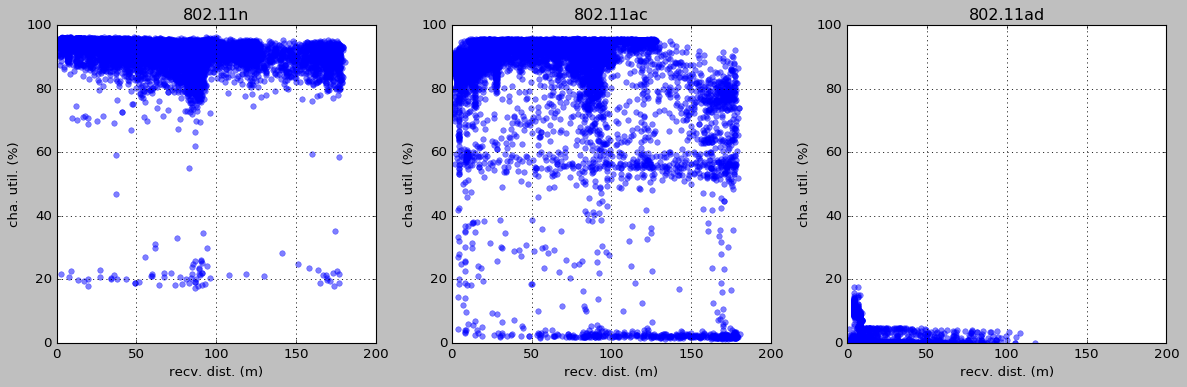

  wifiType  nr-samples
0       ac        8710
1       ad        8710
2        n        8710


In [17]:
import matplotlib
import matplotlib.pyplot as plt

# trim start & and of captures

plt.style.use('classic')
fig = plt.figure(figsize = ((5.0) * 3, (5.0)))

for i, wifi_type in enumerate(['n', 'ac', 'ad']):
    plot_data = dataset[dataset['wifiType'] == wifi_type].sort_values(by = ['receiverDist'])

    ax = fig.add_subplot(1, 3, i + 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.set_title('802.11%s' % (wifi_type))
    ax.plot(plot_data['receiverDist'], plot_data['channelUtil'], color = 'blue', linewidth = 0.0, marker = '.', markersize = 10.0, alpha = .5)
    ax.set_xlabel('recv. dist. (m)')
    ax.set_ylabel('cha. util. (%)')
    ax.set_ylim([0.0, 100.0])
    ax.set_xlim([0.0, 200.0])
    
fig.tight_layout()
plt.show()

with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dataset.groupby(['wifiType']).size().reset_index(drop = False, name = 'nr-samples'))


* Data rate is pretty much a dead ringer for throughput. I'm thinking we should actually focus on predicting data rate rather than throughput. Data rate should be easier to predict as it's independent from the amount of data the client has to send.

# Data rate prediction as a classification problem
I.e. predict data rate as discrete variable.
We discretize data rate as a 4-class variable, with each class representing a different quartile.

Notes regarding classification report:
* **Precision**: TP / (TP + FP), or what percentage of predicted positives are true positives.
* **Recall**: TP / (TP + FN), or what percentage of actual positives were predicted to be positive.
* **F1-score**: can be interpreted as a weighted harmonic mean of precision and recall, (best score is 1, worst is 0).
* **Support**: number of ground truth entries in the corresponding.

### Code

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy

def printSeparator():
  print('----------------------------------------------------------------\n')

def evalClfPerf(clfName, yTest, yPred):
  print("Accuracy of", clfName, ":", accuracy_score(yTest, yPred))
  print(classification_report(yTest, yPred))
  report = classification_report(yTest, yPred, output_dict = True)

  # display a confusion matrix
  print("Confusion matrix:")
  cmat = confusion_matrix(yTest, yPred)
  plt.figure(figsize=(6.5, 6.5)) # new figure
  sn.set(font_scale=1.4) #for label size
  sn.heatmap(cmat, annot=True, annot_kws={"size": 13}, fmt='g') # font size
  plt.show()

  return report

def plotRfFeatImp(x, featNameList, clfRf):
  """
    Plot feature importance over feature data frame x for a random forest classifier clfRf.
  """
  std = numpy.std([tree.feature_importances_ for tree in clfRf.estimators_], axis=0)
  indices = numpy.argsort(clfRf.feature_importances_)[::-1]

  print("Feature importance:")
  plt.figure()
  ax = plt.bar(range(x.shape[1]), clfRf.feature_importances_[indices], yerr=std[indices], \
          align="center", color="r")
  plt.xticks(range(x.shape[1]), [featNameList[i] for i in indices], rotation = 90)
  plt.xlim([-1, x.shape[1]])
  plt.ylim([0, 0.5])
  plt.show()

def runClassifier(clf, clfName, xTrain, yTrain, xTest, yTest):
  """
    Run single classifier, passed in as argument clf.
  """

  clf.fit(xTrain, yTrain)
  yPred = clf.predict(xTest) # predict on the unseen data
  report = evalClfPerf(clfName, yTest, yPred)
  printSeparator()

  return report

def runClassifiersInner(df, targetName, scaler = None, nquantiles = 4, summary_data = []):
  """
    Run multiple classifiers for the data frame passed in as argument df.
  """

  # discretize target

  # start by printing some information about the bins
  uniBins = pandas.qcut(df[targetName], q = nquantiles, duplicates = 'drop').unique()
  uniBins = uniBins.ravel()
  uniBins.sort()
  print("Discretizing", targetName, "into", nquantiles, "quantiles, yielding bins:\n", uniBins)

  df[targetName] = pandas.qcut(df[targetName], q=nquantiles, labels=False, duplicates = 'drop') # actually discretize stuff

  #  split dataset into training and test
  x = df.drop(targetName, axis=1) # x contains all the features
  y = df[targetName] # y contains only the label
  featNameList = list(x.columns)

  # scaling, see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  if scaler:
    x = scaler.fit_transform(x)

  # xTrain contains features for training, xTest contains features for testing
  # test_size = 0.3 means 30% data for testing
  # random_state = 1, is the seed value used by the random number generator
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=1)
  printSeparator()
    
  # train and test models

  # logistic regression
  clfLogr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, random_state=1)
  report = runClassifier(clfLogr, "logistic regression", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'logistic regr.', 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})
    
  # svm
  clfSvm = svm.SVC(gamma='scale', random_state=1)
  report = runClassifier(clfSvm, "support vector machine", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'svm', 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})
    
  # knn
  clfKnn = KNeighborsClassifier()
  report = runClassifier(clfKnn, "k-Nearest Neighbors", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'knn', 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})
    
  # decision tree    
  clfDt = DecisionTreeClassifier(random_state=1)
  report = runClassifier(clfDt, "decision tree", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'dec. tree', 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})
    
  # random forest
  clfRf = RandomForestClassifier(n_estimators=100, random_state=1)
  report = runClassifier(clfRf, "random forest", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'random forest', 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})
  plotRfFeatImp(x, featNameList, clfRf)
    
  # neural network (Multi Layer Perceptron w/ backpropagation)
  clfMlp = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
  report = runClassifier(clfMlp, "neural network - Multi-Layer Perceptron (MLP)", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'neural net', 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})

## Classification on original features
#### Code

In [59]:
def runClassifiersOuterOg(df, featuresToDrop, summary_data):

  clDf = df.copy() # work on copy to preserve original

  # we don't care for some columns no more
  clDf.drop(featuresToDrop, axis=1, inplace=True)
  
  #  split dataset into training and test
  x = clDf.drop("dataRateMean", axis = 1) # x contains all the features
  y = clDf["dataRateMean"] # y contains only the label

  from sklearn.preprocessing import MinMaxScaler
  mms = MinMaxScaler() # subtract minimum and divide by range
  runClassifiersInner(df = clDf, targetName = "dataRateMean", scaler = mms, nquantiles = 4, summary_data = summary_data)

### Classification with client location data
Requires some communication from client to AP.

In [61]:
featuresToDrop = ['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                  'senderId', 'receiverId', \
                  'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon']
featuresToUse = [x for x in list(dataset.columns) if x not in featuresToDrop]
print(featuresToUse)

['receiverAlt', 'receiverX', 'receiverY', 'receiverDist', 'receiverSpeed', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean', 'nRetries', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']


Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(-0.001, 21.27, closed='right')
 Interval(21.27, 70.801, closed='right')
 Interval(70.801, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.8951396861844623
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3864
           1       0.82      0.86      0.84      1998
           2       0.91      0.84      0.87      1977

    accuracy                           0.90      7839
   macro avg       0.88      0.88      0.88      7839
weighted avg       0.90      0.90      0.90      7839

Confusion matrix:


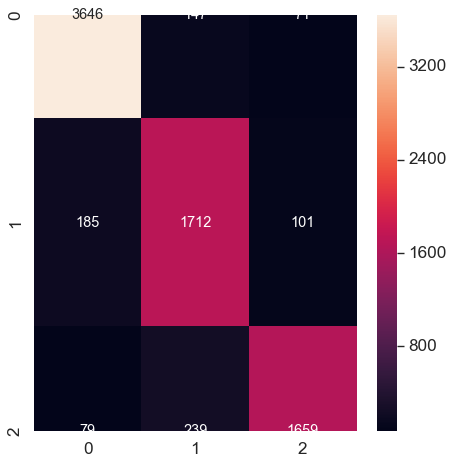

----------------------------------------------------------------

Accuracy of support vector machine : 0.9274142109963005
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3864
           1       0.86      0.93      0.89      1998
           2       0.93      0.86      0.90      1977

    accuracy                           0.93      7839
   macro avg       0.92      0.92      0.92      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


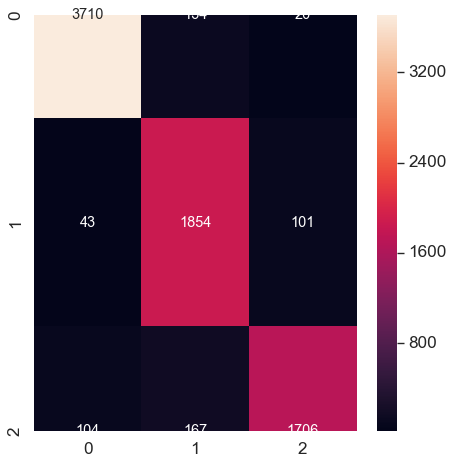

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.9373644597525195
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3864
           1       0.90      0.91      0.91      1998
           2       0.92      0.90      0.91      1977

    accuracy                           0.94      7839
   macro avg       0.93      0.93      0.93      7839
weighted avg       0.94      0.94      0.94      7839

Confusion matrix:


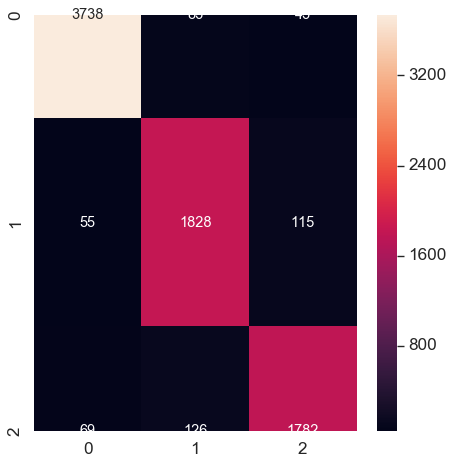

----------------------------------------------------------------

Accuracy of decision tree : 0.9424671514223752
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3864
           1       0.92      0.90      0.91      1998
           2       0.91      0.92      0.92      1977

    accuracy                           0.94      7839
   macro avg       0.93      0.93      0.93      7839
weighted avg       0.94      0.94      0.94      7839

Confusion matrix:


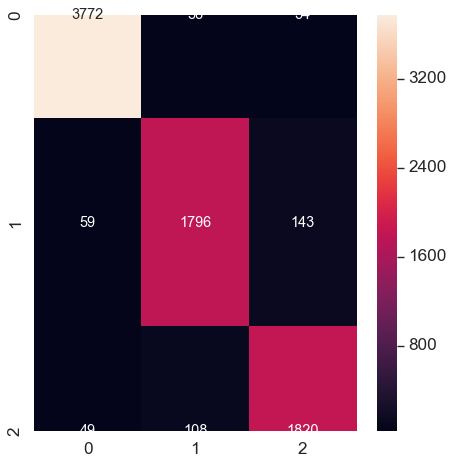

----------------------------------------------------------------

Accuracy of random forest : 0.9584130628906748
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3864
           1       0.92      0.95      0.94      1998
           2       0.95      0.93      0.94      1977

    accuracy                           0.96      7839
   macro avg       0.95      0.95      0.95      7839
weighted avg       0.96      0.96      0.96      7839

Confusion matrix:


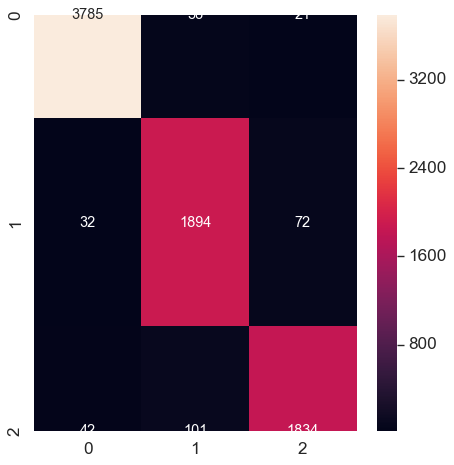

----------------------------------------------------------------

Feature importance:


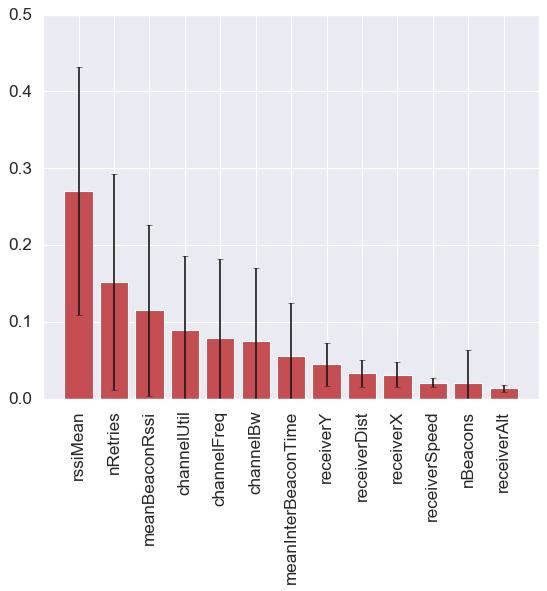

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.9465493047582599
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3864
           1       0.91      0.93      0.92      1998
           2       0.93      0.91      0.92      1977

    accuracy                           0.95      7839
   macro avg       0.94      0.94      0.94      7839
weighted avg       0.95      0.95      0.95      7839

Confusion matrix:


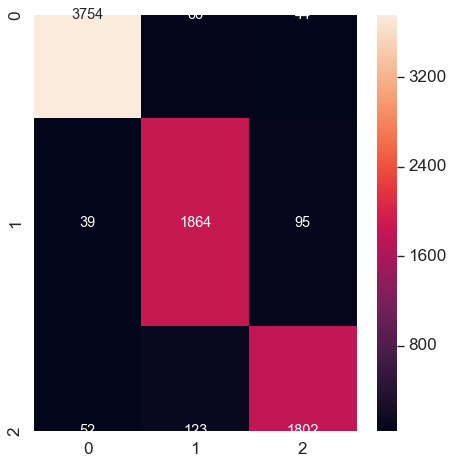

----------------------------------------------------------------



In [62]:
with_location = []
runClassifiersOuterOg(df = dataset, featuresToDrop = featuresToDrop, summary_data = with_location)

### Classification without client location data
Doesn't require communication from client to AP.

In [56]:
featuresToDrop = ['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                  'senderId', 'receiverId', 'receiverDist', \
                  'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon', \
                  'receiverId', 'receiverX', 'receiverY', \
                  'receiverDist', 'receiverSpeed', 'receiverAlt']
featuresToUse = [x for x in list(dataset.columns) if x not in featuresToDrop]
print(featuresToUse)

['rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean', 'nRetries', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']


Discretizing dataRateMean into 5 quantiles, yielding bins:
 [Interval(-0.001, 41.153, closed='right')
 Interval(41.153, 117.06, closed='right')
 Interval(117.06, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.9145299145299145
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4651
           1       0.88      0.81      0.84      1612
           2       0.85      0.91      0.88      1576

    accuracy                           0.91      7839
   macro avg       0.89      0.89      0.89      7839
weighted avg       0.91      0.91      0.91      7839

Confusion matrix:


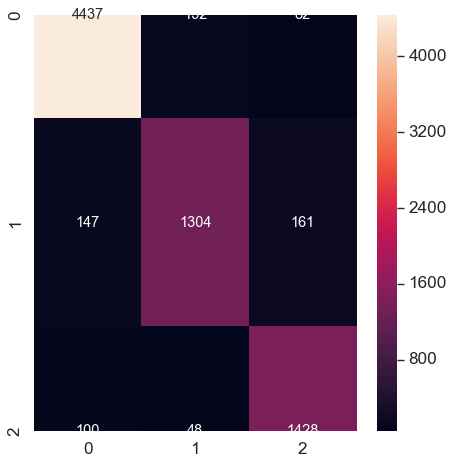

----------------------------------------------------------------

Accuracy of support vector machine : 0.925628268911851
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4651
           1       0.91      0.83      0.87      1612
           2       0.90      0.87      0.89      1576

    accuracy                           0.93      7839
   macro avg       0.92      0.89      0.90      7839
weighted avg       0.92      0.93      0.92      7839

Confusion matrix:


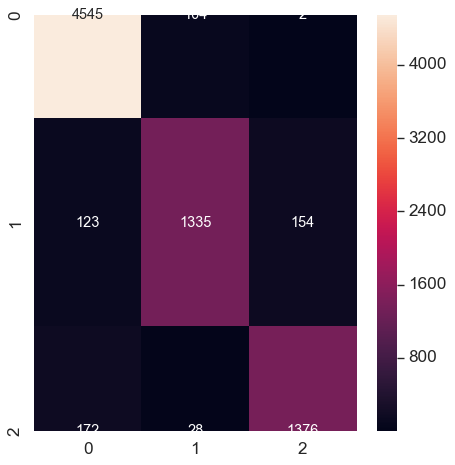

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.934302844750606
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4651
           1       0.88      0.87      0.88      1612
           2       0.92      0.90      0.91      1576

    accuracy                           0.93      7839
   macro avg       0.92      0.91      0.92      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


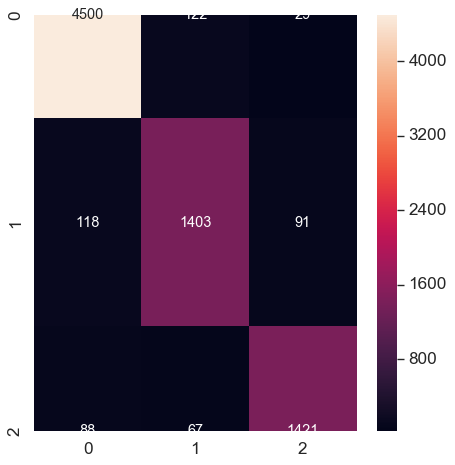

----------------------------------------------------------------

Accuracy of decision tree : 0.9274142109963005
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4651
           1       0.87      0.85      0.86      1612
           2       0.91      0.91      0.91      1576

    accuracy                           0.93      7839
   macro avg       0.91      0.91      0.91      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


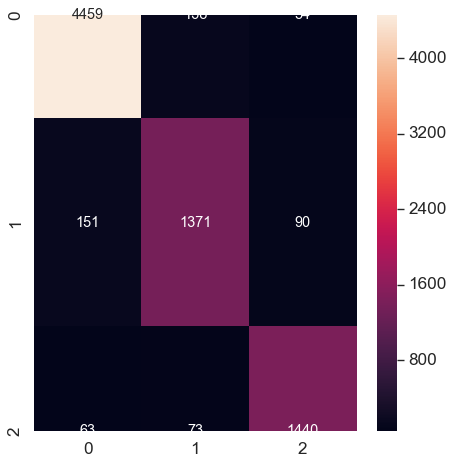

----------------------------------------------------------------

Accuracy of random forest : 0.941701747671897
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4651
           1       0.89      0.88      0.89      1612
           2       0.93      0.92      0.92      1576

    accuracy                           0.94      7839
   macro avg       0.93      0.92      0.93      7839
weighted avg       0.94      0.94      0.94      7839

Confusion matrix:


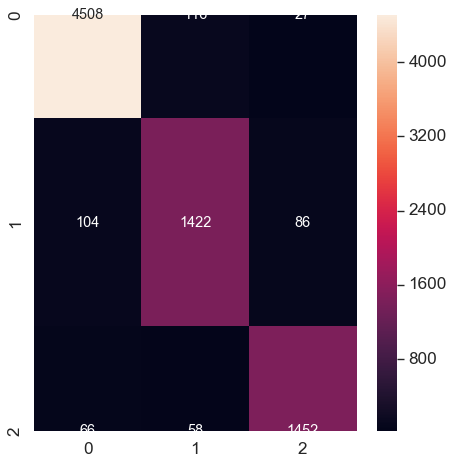

----------------------------------------------------------------

Feature importance:


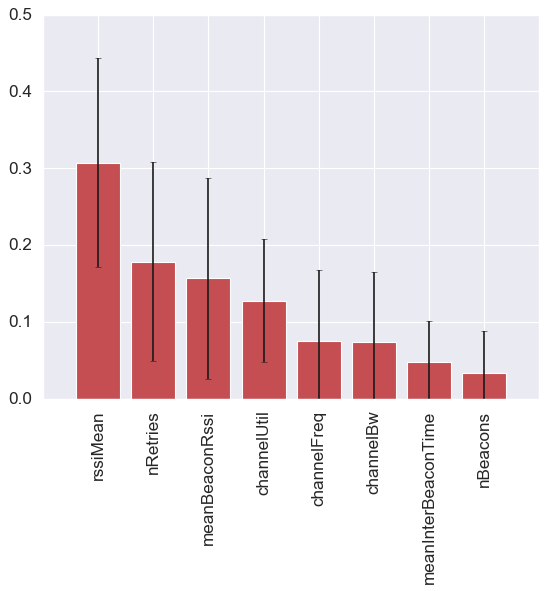

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.9367266232937874
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4651
           1       0.90      0.88      0.89      1612
           2       0.93      0.90      0.91      1576

    accuracy                           0.94      7839
   macro avg       0.93      0.92      0.92      7839
weighted avg       0.94      0.94      0.94      7839

Confusion matrix:


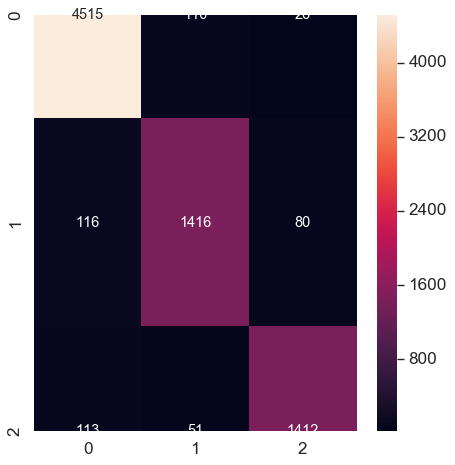

----------------------------------------------------------------



In [57]:
no_location = []
runClassifiersOuterOg(df = dataset, featuresToDrop = featuresToDrop, summary_data = no_location)

### Classification summary : with location data

In [54]:
with_location = pandas.DataFrame(with_location)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(with_location.sort_values(by = ['acc']))

           method       acc      prec    recall        f1
0  logistic regr.  0.912999  0.892274  0.888126  0.889587
1             svm  0.930986  0.916505  0.904079  0.909547
2             knn  0.938895  0.924591  0.922048  0.923304
3       dec. tree  0.942850  0.928936  0.926493  0.927674
5      neural net  0.948080  0.935010  0.934567  0.934763
4   random forest  0.955096  0.945163  0.941780  0.943458


### Classification summary : no location data

In [58]:
no_location = pandas.DataFrame(no_location)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(no_location.sort_values(by = ['acc']))

           method       acc      prec    recall        f1
0  logistic regr.  0.914530  0.893517  0.889671  0.890858
1             svm  0.925628  0.915747  0.892823  0.903457
3       dec. tree  0.927414  0.909973  0.907640  0.908778
2             knn  0.934303  0.919879  0.913177  0.916467
5      neural net  0.936727  0.926602  0.915037  0.920646
4   random forest  0.941702  0.927478  0.924236  0.925843


## Classification on principal components

In [70]:
def getPcaDf(df, features, targetVar = 0.95):
  # separate features from target
  x = df.loc[:, features].values # x represents our features

  # standardization, see the following articles: 
  # 1. https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  # 2. https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2
  from sklearn.preprocessing import StandardScaler
  x = StandardScaler().fit_transform(x) # subtract mean and then scale to unit variance

  # run PCA
  from sklearn import decomposition
  pca = decomposition.PCA(targetVar) # maintain a targetVar portion of the variance
  pca.fit(x) 

  print("Found", pca.n_components_, "PCA components:", pca.explained_variance_)
  print("Explained variance ratios:", pca.explained_variance_ratio_, "total:", \
        sum(pca.explained_variance_ratio_))

  prinComps = pca.transform(x) # apply dimensionality reduction to x

  # create a data frame out of x
  pcaDf = pandas.DataFrame(data = prinComps)
  pcaDf['dataRateMean'] =  df['dataRateMean']
    
  return pcaDf

def runClassifiersOuterPc(df, featuresOfInterest, summary_data = []):
  pcaDf = getPcaDf(df = df, features = featuresOfInterest)
  runClassifiersInner(df = pcaDf, targetName = "dataRateMean", scaler = None, nquantiles = 4, summary_data = summary_data)

### Classification with client location info

['receiverAlt', 'receiverX', 'receiverY', 'receiverSpeed', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'nRetries', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']
Found 9 PCA components: [3.7508059  1.95393073 1.47068491 1.0736745  0.93694999 0.91466856
 0.7929673  0.4552167  0.31180282]
Explained variance ratios: [0.3125552  0.16282133 0.12255239 0.08946945 0.07807618 0.07621946
 0.06607808 0.03793327 0.02598257] total: 0.9716879308272551
Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(-0.001, 21.27, closed='right')
 Interval(21.27, 70.801, closed='right')
 Interval(70.801, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.8938640132669984
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3864
           1       0.82      0.86      0.84      1998
           2       0.90      0.84      0.87      1977

    accuracy      

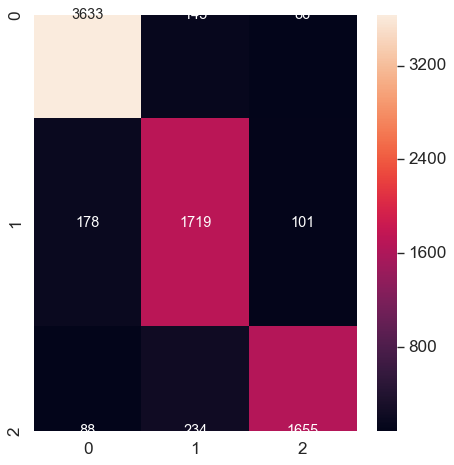

----------------------------------------------------------------

Accuracy of support vector machine : 0.9328996045413955
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3864
           1       0.87      0.93      0.90      1998
           2       0.94      0.87      0.91      1977

    accuracy                           0.93      7839
   macro avg       0.93      0.92      0.92      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


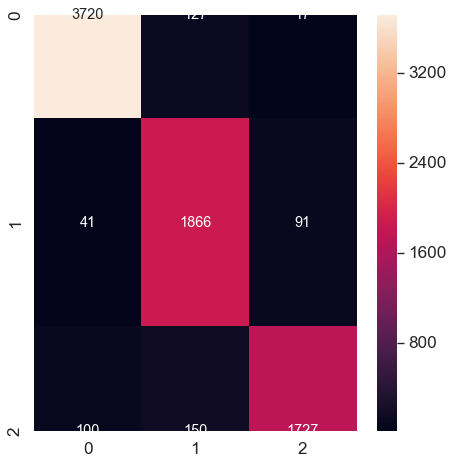

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.9348131139175915
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3864
           1       0.88      0.91      0.90      1998
           2       0.92      0.91      0.91      1977

    accuracy                           0.93      7839
   macro avg       0.92      0.93      0.93      7839
weighted avg       0.94      0.93      0.93      7839

Confusion matrix:


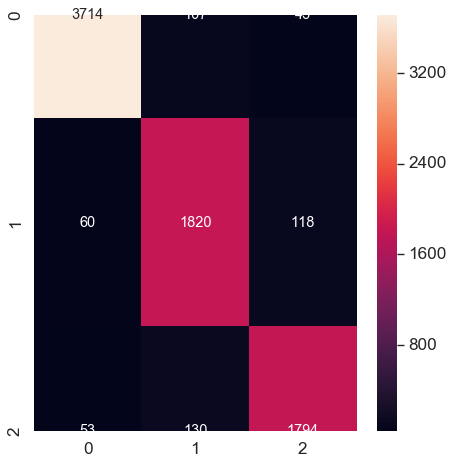

----------------------------------------------------------------

Accuracy of decision tree : 0.9123612705702258
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3864
           1       0.86      0.86      0.86      1998
           2       0.89      0.88      0.88      1977

    accuracy                           0.91      7839
   macro avg       0.90      0.90      0.90      7839
weighted avg       0.91      0.91      0.91      7839

Confusion matrix:


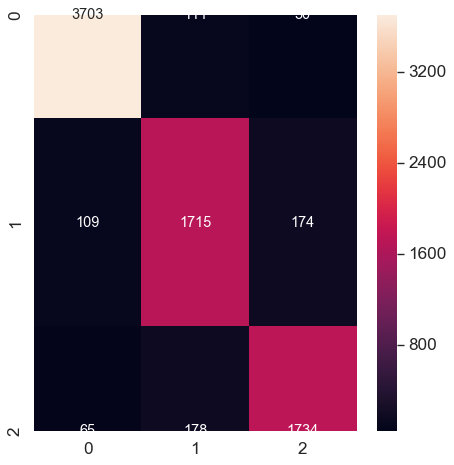

----------------------------------------------------------------

Accuracy of random forest : 0.9396606710039546
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3864
           1       0.89      0.92      0.90      1998
           2       0.93      0.90      0.92      1977

    accuracy                           0.94      7839
   macro avg       0.93      0.93      0.93      7839
weighted avg       0.94      0.94      0.94      7839

Confusion matrix:


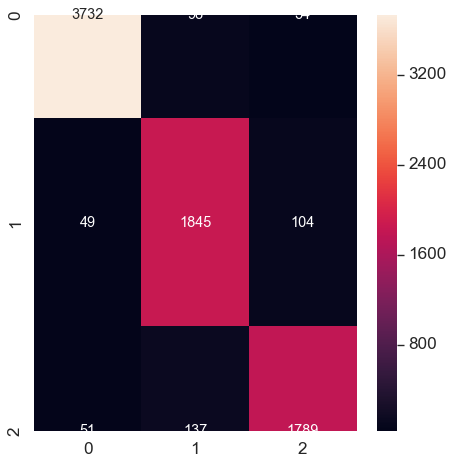

----------------------------------------------------------------

Feature importance:


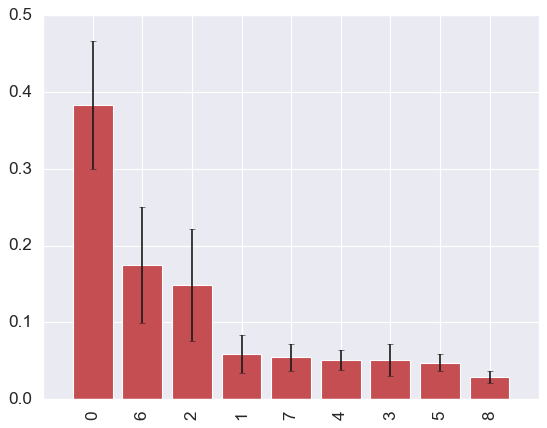

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.9406812093379258
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3864
           1       0.90      0.92      0.91      1998
           2       0.92      0.91      0.91      1977

    accuracy                           0.94      7839
   macro avg       0.93      0.93      0.93      7839
weighted avg       0.94      0.94      0.94      7839

Confusion matrix:


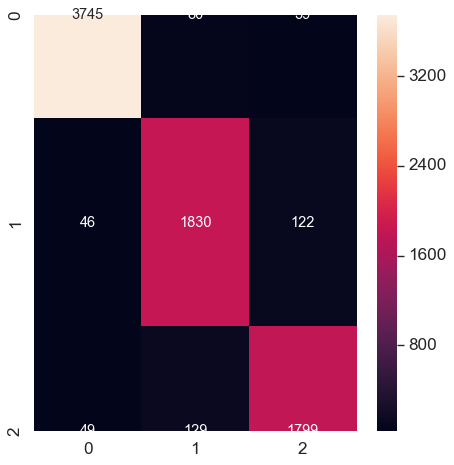

----------------------------------------------------------------



In [69]:
with_location = []
runClassifiersOuterPc(
    df = dataset, 
    featuresOfInterest = ['receiverAlt', 'receiverX', 'receiverY', 'receiverSpeed', \
                          'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', \
                          'nRetries', 'meanBeaconRssi', \
                          'meanInterBeaconTime', 'nBeacons'], 
    summary_data = with_location)

### Classification without client location info

Found 5 PCA components: [3.72380797 1.44983347 1.10211763 0.84000748 0.50163557]
Explained variance ratios: [0.46545818 0.18122225 0.13775943 0.10499692 0.06270205] total: 0.9521388247707104
Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(-0.001, 21.27, closed='right')
 Interval(21.27, 70.801, closed='right')
 Interval(70.801, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.8807245822171196
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3864
           1       0.80      0.85      0.82      1998
           2       0.89      0.82      0.85      1977

    accuracy                           0.88      7839
   macro avg       0.87      0.87      0.87      7839
weighted avg       0.88      0.88      0.88      7839

Confusion matrix:


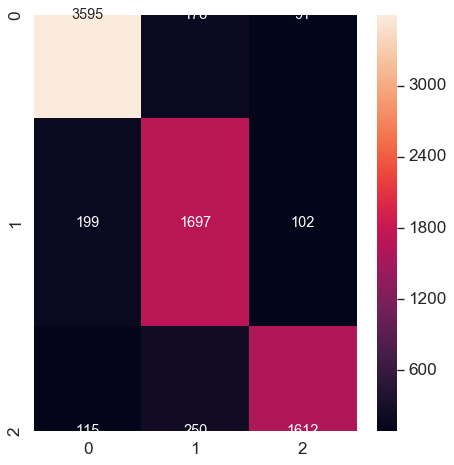

----------------------------------------------------------------

Accuracy of support vector machine : 0.9191223370327848
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3864
           1       0.86      0.91      0.89      1998
           2       0.94      0.83      0.88      1977

    accuracy                           0.92      7839
   macro avg       0.91      0.90      0.91      7839
weighted avg       0.92      0.92      0.92      7839

Confusion matrix:


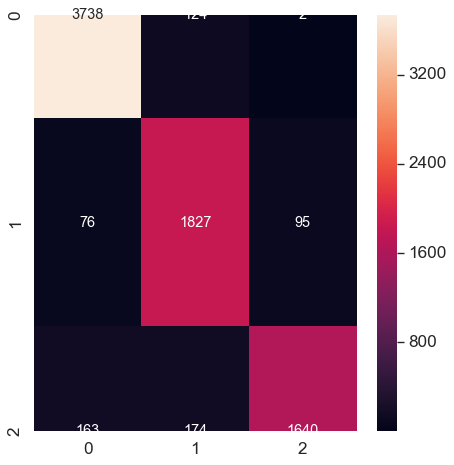

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.9252455670366118
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3864
           1       0.87      0.90      0.89      1998
           2       0.91      0.86      0.89      1977

    accuracy                           0.93      7839
   macro avg       0.91      0.91      0.91      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


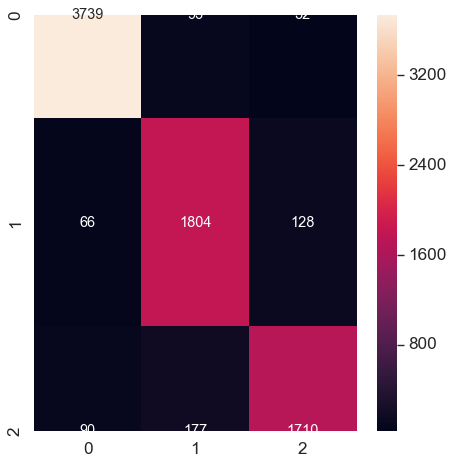

----------------------------------------------------------------

Accuracy of decision tree : 0.9062380405663988
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3864
           1       0.85      0.86      0.85      1998
           2       0.87      0.86      0.87      1977

    accuracy                           0.91      7839
   macro avg       0.89      0.89      0.89      7839
weighted avg       0.91      0.91      0.91      7839

Confusion matrix:


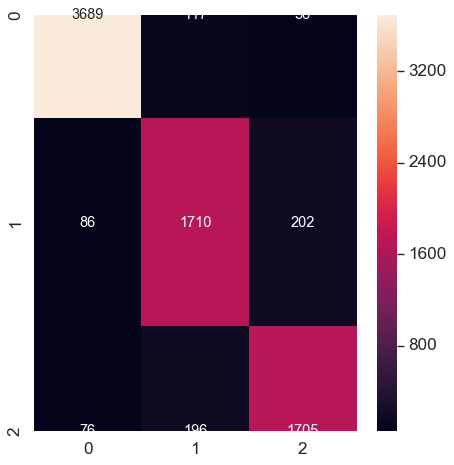

----------------------------------------------------------------

Accuracy of random forest : 0.9258834034953438
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3864
           1       0.87      0.91      0.89      1998
           2       0.92      0.87      0.89      1977

    accuracy                           0.93      7839
   macro avg       0.92      0.91      0.91      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


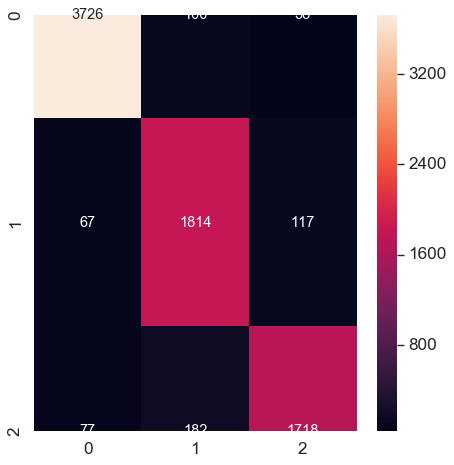

----------------------------------------------------------------

Feature importance:


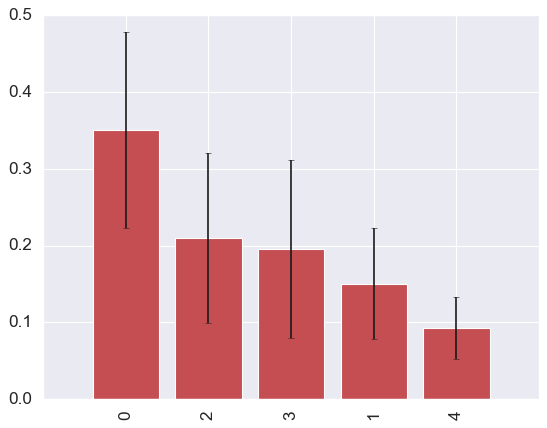

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.931113662456946
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3864
           1       0.88      0.92      0.90      1998
           2       0.93      0.87      0.90      1977

    accuracy                           0.93      7839
   macro avg       0.92      0.92      0.92      7839
weighted avg       0.93      0.93      0.93      7839

Confusion matrix:


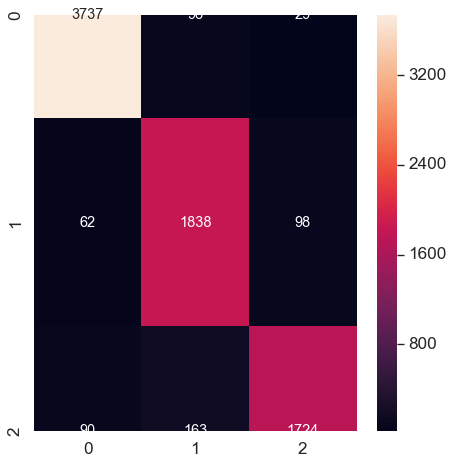

----------------------------------------------------------------



In [74]:
no_location = []
runClassifiersOuterPc(df = dataset, featuresOfInterest = ['rssiMean', 'channelFreq', 'channelBw', 'channelUtil', \
                                                          'nRetries', 'meanBeaconRssi', \
                                                          'meanInterBeaconTime', 'nBeacons'], summary_data = no_location)

### PCA summary : with location

In [71]:
with_location = pandas.DataFrame(with_location)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(with_location.sort_values(by = ['acc']))

           method       acc      prec    recall        f1
0  logistic regr.  0.893864  0.883203  0.879235  0.880684
3       dec. tree  0.912361  0.898835  0.897926  0.898372
1             svm  0.932900  0.925122  0.923404  0.923475
2             knn  0.934813  0.924301  0.926509  0.925325
4   random forest  0.939661  0.929770  0.931389  0.930402
5      neural net  0.940681  0.930205  0.931694  0.930910


### PCA summary : no location

In [75]:
no_location = pandas.DataFrame(no_location)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(no_location.sort_values(by = ['acc']))

           method       acc      prec    recall        f1
0  logistic regr.  0.880725  0.870445  0.865036  0.866881
3       dec. tree  0.906238  0.890299  0.890995  0.890632
1             svm  0.919122  0.914609  0.903782  0.907614
2             knn  0.925246  0.914735  0.911833  0.912946
4   random forest  0.925883  0.915165  0.913729  0.914060
5      neural net  0.931114  0.922653  0.919694  0.920662


# Data rate prediction as a regression problem
Predict data rate as a continuous variable.

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

def rmse(yTrue, yPred):
  """
    Compute root mean square error.
  """
  return numpy.sqrt(numpy.mean(numpy.square(yTrue - yPred)))

def testRegUnderClass(regName, yTrain, yTest, yPred, nquantiles=5):
  """
    See how well regression does under the classification task.
  """
  ySeries = pandas.concat([yTrain, yTest])
  _, bins = pandas.qcut(ySeries, q = nquantiles, labels = False, retbins = True, duplicates = 'drop') # actually discretize stuff
  bins[0] = -1.0 # ensure zeros fit in 1st interval
  yTestCat = pandas.cut(yTest, bins = bins, labels = False)
  yPredCat = pandas.cut(yPred, bins = bins, labels = False)
    
  # FIXME : remove 'out of bounds' values from both yTestCat and yPredCat
  yTestCat = yTestCat.values
  ixs = np.argwhere(~np.isnan(yPredCat)).reshape(-1)
  report = evalClfPerf(regName, yTestCat[ixs], yPredCat[ixs])

  return report

def runRegression(reg, regName, xTrain, yTrain, xTest, yTest, printSep=True):
  """
    Run single regression, passed in as argument reg.
  """

  print(regName)
  reg.fit(xTrain, yTrain)
  yPred = reg.predict(xTest) # predict on the unseen data
  yPred = yPred.clip(min = 0.0) # because we know data rate can't be negative, make negative values zero

  rmse_val = rmse(yTest, yPred)
  r2_score_val = r2_score(yTest, yPred)
  print("Root-Mean-Square Error: %.2f" % rmse_val)
  print('Variance score: %.2f' % r2_score_val) # 1 is perfect prediction
  
  report = testRegUnderClass(regName, yTrain, yTest, yPred)

  if printSep: printSeparator()
  
  return yPred, rmse_val, r2_score_val, report

def runRegressionsInner(df, targetName, scaler=None, summary_data = []):
  """
    Run multiple regressions for the data frame passed in as argument df.
  """

  #  split dataset into training and test
  x = df.drop(targetName, axis=1) # x contains all the features
  y = df[targetName] # y contains only the label

  # scaling, see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  if scaler:
    x = scaler.fit_transform(x)

  # xTrain contains features for training, xTest contains features for testing
  # test_size = 0.3 means 30% data for testing
  # random_state = 1, is the seed value used by the random number generator
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 1)    
    
  # some info about the data
  print("Train y data information - min:", numpy.min(yTrain), ", max:", numpy.max(yTrain), ', mean:', \
        numpy.mean(yTrain), ", standard deviation:", numpy.std(yTrain))
  print("Test y data information - min:", numpy.min(yTest), ", max:", numpy.max(yTest), ', mean:', \
        numpy.mean(yTest), ", standard deviation:", numpy.std(yTest))
  printSeparator()
    
  # train and test models

  # linear regression
  regLinr = LinearRegression()
  yPredLinr, rmse_val, r2_score_val, report = runRegression(regLinr, "Linear regression", xTrain, yTrain, xTest, yTest, printSep=False)
#  print('Linear regression coefs: \n', regLinr.coef_)
  summary_data.append({'method' : 'linear regr.', 'rmse' : rmse_val, 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})
  printSeparator()

  # svr
  regSvr = svm.SVR(gamma='scale')
  yPredSvr, rmse_val, r2_score_val, report = runRegression(regSvr, "Support Vector Regression (SVR)", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'svr', 'rmse' : rmse_val, 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})

  # neural network (Multi Layer Perceptron w/ backpropagation)
  regMlp = MLPRegressor(solver='lbfgs', random_state=1, max_iter=1000)
  yPredMlp, rmse_val, r2_score_val, report = runRegression(regMlp, "Neural network - Multi-Layer Perceptron (MLP)", xTrain, yTrain, xTest, yTest)
  summary_data.append({'method' : 'neural net.', 'rmse' : rmse_val, 'acc' : report['accuracy'], 'prec' : report['macro avg']['precision'], 'recall' : report['macro avg']['recall'], 'f1' : report['macro avg']['f1-score']})  
  y = numpy.array([yTrain, yTest, yPredLinr, yPredSvr, yPredMlp]) 

  # plot violins for the different y distributions
  vioInPairs = (('Train', yTrain.values), ('Test', yTest.values), ('Linear regression', yPredLinr), \
                ('Support vector regression', yPredSvr), ('Multi-layer perceptron', yPredMlp))
  vioDf = pandas.DataFrame(columns=['Dataset','Mean data rate (Mbit/s)'])
  crow = 0
  for x, yarray in vioInPairs:
    for y in yarray:
      vioDf.loc[crow] = [x, y]
      crow += 1
        
  plt.figure(figsize=(14,8)) # new figure
  sns.set(style="whitegrid")
  sns.violinplot(x='Dataset', y='Mean data rate (Mbit/s)', data=vioDf)
  plt.show()

## Classification on original features
#### Code

In [77]:
def runRegressionsOuterOg(df, featuresToDrop, summary_data = []): 
  regDf = df.copy() # work on copy to preserve original

  # we don't care for some columns no more
  regDf.drop(featuresToDrop, axis=1, inplace=True)
  
  #  split dataset into training and test
  x = regDf.drop("dataRateMean", axis = 1) # x contains all the features
  y = regDf["dataRateMean"] # y contains only the label

  from sklearn.preprocessing import MinMaxScaler
  mms = MinMaxScaler() # subtract minimum and divide by range
  runRegressionsInner(df = regDf, targetName = "dataRateMean", scaler=mms, summary_data = summary_data)

### Classification with client location info

Train y data information - min: 0.0 , max: 2310.0 , mean: 93.36576120229958 , standard deviation: 205.20058031713432
Test y data information - min: 0.0 , max: 2310.0 , mean: 95.06001258401915 , standard deviation: 214.26823281030644
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 158.25
Variance score: 0.45
[-1.00000000e+00  4.11529385e+01  1.17060053e+02  2.31000000e+03]
[   0    1    2 ... 7836 7837 7838]
[2 1 0 ... 2 0 0]
[2 1 0 ... 2 0 2]
Accuracy of Linear regression : 0.8341625207296849
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      4651
           1       0.67      0.66      0.66      1612
           2       0.75      0.99      0.85      1576

    accuracy                           0.83      7839
   macro avg       0.79      0.83      0.80      7839
weighted avg       0.84      0.83      0.83      7839

Confusion matrix:


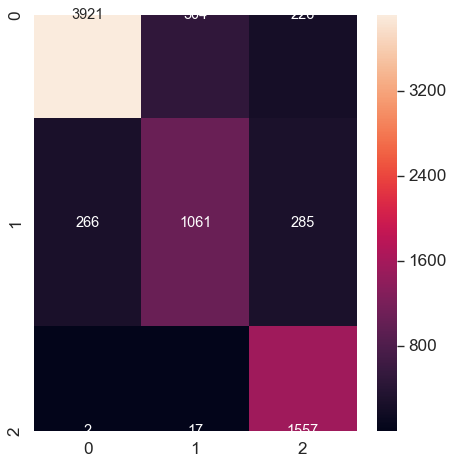

----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 194.41
Variance score: 0.18
[-1.00000000e+00  4.11529385e+01  1.17060053e+02  2.31000000e+03]
[   0    1    2 ... 7836 7837 7838]
[2 1 0 ... 2 0 0]
[2 1 0 ... 2 0 1]
Accuracy of Support Vector Regression (SVR) : 0.8201301186375813
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      4651
           1       0.54      0.92      0.68      1612
           2       0.93      0.76      0.84      1576

    accuracy                           0.82      7839
   macro avg       0.82      0.83      0.80      7839
weighted avg       0.88      0.82      0.83      7839

Confusion matrix:


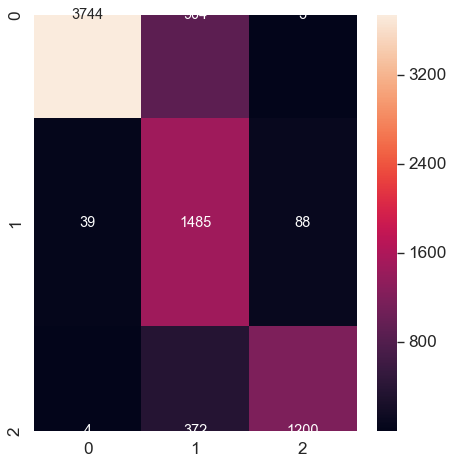

----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 137.35
Variance score: 0.59
[-1.00000000e+00  4.11529385e+01  1.17060053e+02  2.31000000e+03]
[   0    1    2 ... 7836 7837 7838]
[2 1 0 ... 2 0 0]
[2 1 0 ... 2 0 1]
Accuracy of Neural network - Multi-Layer Perceptron (MLP) : 0.9183569332823064
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4651
           1       0.83      0.86      0.84      1612
           2       0.88      0.94      0.91      1576

    accuracy                           0.92      7839
   macro avg       0.89      0.91      0.90      7839
weighted avg       0.92      0.92      0.92      7839

Confusion matrix:


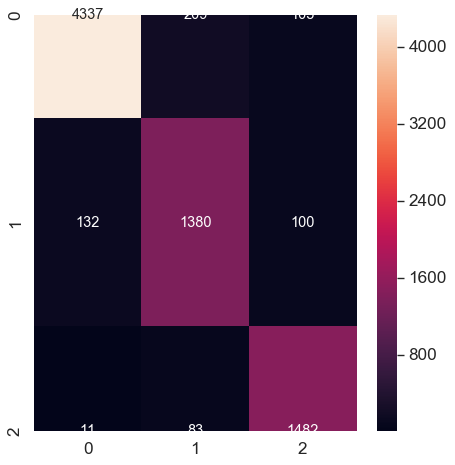

----------------------------------------------------------------



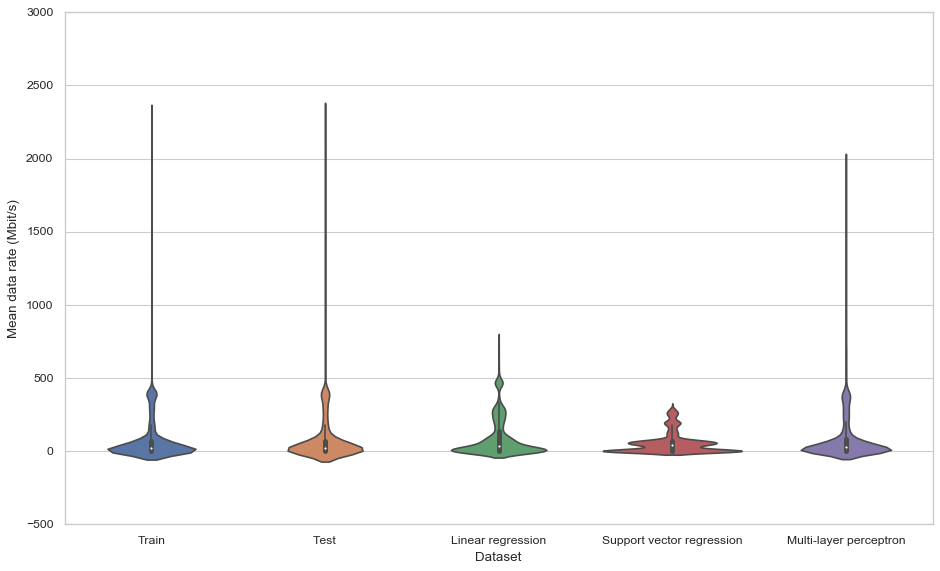

In [78]:
featuresToDrop = ['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                  'senderId', 'receiverId', \
                  'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon']

with_location = []
runRegressionsOuterOg(df = dataset, featuresToDrop = featuresToDrop, summary_data = with_location)

### Classification without client location info

Train y data information - min: 0.0 , max: 2310.0 , mean: 93.36576120229958 , standard deviation: 205.20058031713432
Test y data information - min: 0.0 , max: 2310.0 , mean: 95.06001258401915 , standard deviation: 214.26823281030644
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 158.39
Variance score: 0.45
Accuracy of Linear regression : 0.8479397882382957
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4651
           1       0.71      0.68      0.70      1612
           2       0.75      0.99      0.86      1576

    accuracy                           0.85      7839
   macro avg       0.80      0.84      0.82      7839
weighted avg       0.86      0.85      0.85      7839

Confusion matrix:


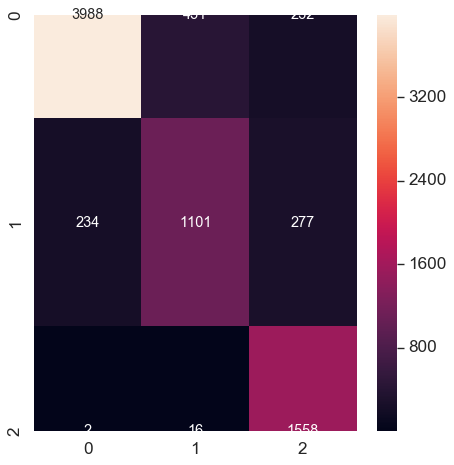

----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 197.63
Variance score: 0.15
Accuracy of Support Vector Regression (SVR) : 0.8788110728409236
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      4651
           1       0.71      0.89      0.79      1612
           2       0.89      0.80      0.84      1576

    accuracy                           0.88      7839
   macro avg       0.85      0.86      0.85      7839
weighted avg       0.89      0.88      0.88      7839

Confusion matrix:


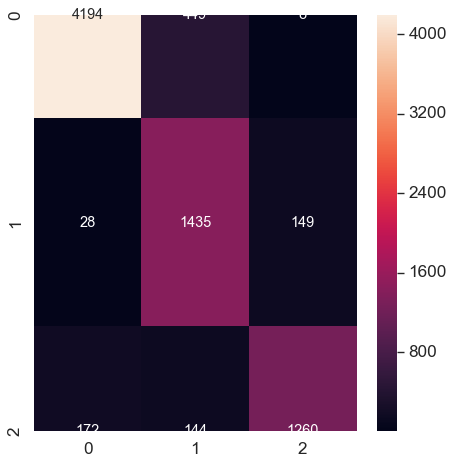

----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 147.09
Variance score: 0.53
Accuracy of Neural network - Multi-Layer Perceptron (MLP) : 0.9056002041076668
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      4651
           1       0.80      0.90      0.84      1612
           2       0.84      0.96      0.90      1576

    accuracy                           0.91      7839
   macro avg       0.87      0.92      0.89      7839
weighted avg       0.91      0.91      0.91      7839

Confusion matrix:


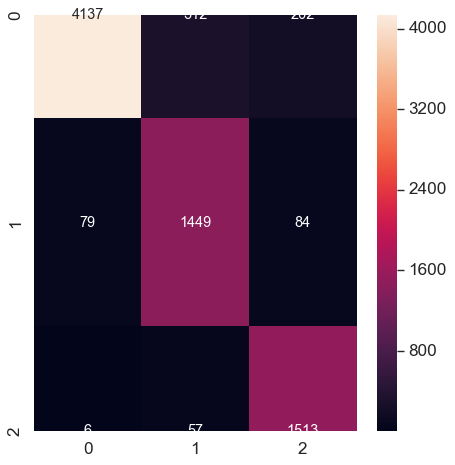

----------------------------------------------------------------



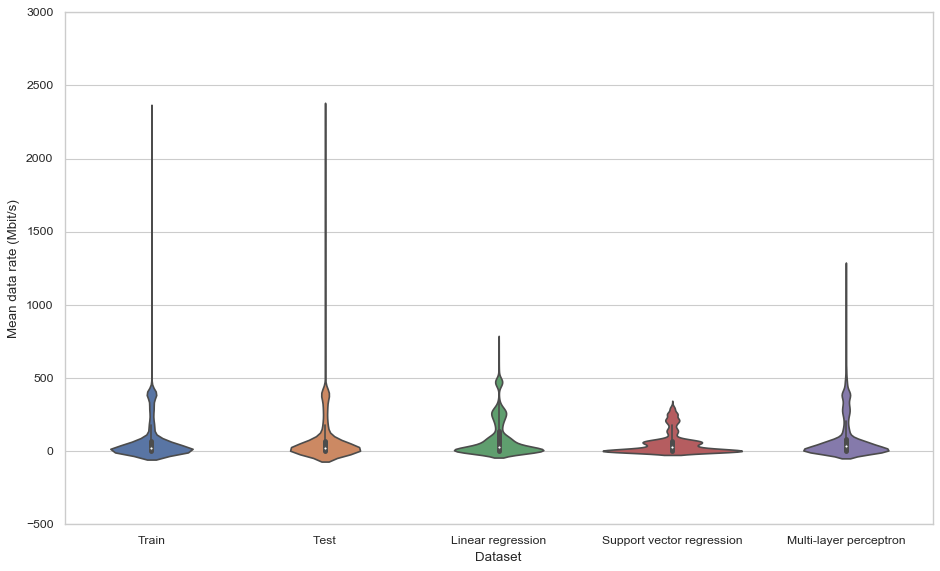

In [82]:
no_location = []
runRegressionsOuterOg(df = dataset, \
                      featuresToDrop = ['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                                      'senderId', 'receiverId', 'receiverDist', \
                                      'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon', \
                                      'receiverId', 'receiverX', 'receiverY', \
                                      'receiverDist', 'receiverSpeed', 'receiverAlt'], summary_data = no_location)

### Regression summary : with location

In [81]:
with_location = pandas.DataFrame(with_location)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(with_location.sort_values(by = ['acc']))

         method        rmse       acc      prec    recall        f1
1           svr  194.406500  0.820130  0.818669  0.829208  0.801231
0  linear regr.  158.250432  0.834163  0.786531  0.829726  0.802010
2   neural net.  137.351888  0.918357  0.890641  0.909641  0.899585


### Regression summary : no location

In [ ]:
no_location = pandas.DataFrame(no_location)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(no_location.sort_values(by = ['acc']))